# faz os imports e configuracoes que serao utilizadas

In [932]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 10000)
pd.options.display.float_format = '{:,.4f}'.format

# inicia os metodos de parser e auxiliares

# MB-LF

In [933]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


In [934]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string

    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        # if 'GMSC' in spname and 'ASHT' in spname[2]:
        #     for c in columns[:-2]:
        #         ret_string += str(spline[c]) + ','
        #     ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,x,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [935]:
def add_label_column_df(df):
    df_new = df[df.batch_size == 500]

    # df.batch_size[df.batch_size == 1] = 'Sequential'
    # df.batch_size[df.batch_size == 0] = 'MB'
    df_new.batch_size[df_new.batch_size == 500] = 'MB-LF'
    
    return df_new

In [936]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [937]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [938]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [939]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/loop-fusion/acc/all-batches"
wantedCSVfilename = "data-batch-vs-acc-600-1200-first.csv"

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


In [940]:
resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

dfmblf = load_df(f'{csvFile}')
dfmblf = add_label_column_df(dfmblf) ## resultados preditivos


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/2923655262.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.batch_size[df_new.batch_size == 500] = 'MB-LF'


In [941]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/loop-fusion/coletor-energia/05092023/loop-fusion'
# PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/loop-fusion/coletor-energia/final/first/600/1200'

In [942]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','

    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,methodology,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True

        return (pstr[:-1])

In [943]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
                'methodology', 'instances', 'time', 'delay', 'out_rate', 'acc']]

In [944]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [945]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate,methodology = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate,methodology = spline
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [946]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [947]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 
               'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

In [948]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': [], 'methodology': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')

                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate, methodology = spline[1:]
                    else:
                        dataset, alg, bsize, rate, methodology = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
                    d['methodology'].append(methodology)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

In [949]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [950]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [951]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.10

    alg_order = ['MB-LF', 'MB-D']
    labels = ['10%', '50%', '90%']

    line_format = ['dotted', '.']
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 1
    for i in range(versions):
        adf = df.iloc[i]

        values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [952]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []

    df_mbd = df[df.label == "MB-D"]
    df = df.drop(df[df.label == "MB-D"].index)

    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#         display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
       
        # debug print, if it shows it is wrong
        # display(showdf)

        df_mbd = filter_by_substring_algorithm(df_mbd, alg).sort_values(['algorithm','batch_size','cores'])
        df_mbd = df_mbd[df_mbd.dataset == ds]
        showdf = pd.concat([showdf, df_mbd])

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False

            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)    

In [953]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, freq='600', tput=False):
    ps = f'{freq}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']

    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=3, bbox_to_anchor=(0.5, -0.10))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

In [954]:
def read_data_create_final_dataframe(freq, DEBUG=False, times='first'):
    d = {}
    global header_printed
    header_printed = False
    # folder_path = f"{PATH_TO_RESULTS}{times}/{freq['minimum']}/{freq['maximum']}"
    folder_path = f"{PATH_TO_RESULTS}"
    # min = freq['minimum']
    # max = freq['maximum']
    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc", "methodology"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    # d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-{max}-freq-min-{min}.log', d)
    d = exper_order_to_dict(f'{folder_path}/exper_order.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')

    #join dfs
    finaldf = moaDF.merge(mdf, on=[ 'algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])

    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    # finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']

    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}tdf.csv")    
    return tdf

In [955]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df.batch_size.unique()
    return df

In [956]:
dataframes_mblf = []
dataframes_mblf.append(read_data_create_final_dataframe("", True))

dfmblf2 = add_label_column_df(dataframes_mblf[0])
dfmblf2['label'] = 'MB-LF'


moaDF: 216    mdf: 216     sshDF: 213


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/2923655262.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.batch_size[df_new.batch_size == 500] = 'MB-LF'
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/1827244450.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmblf2['label'] = 'MB-LF'


# Prepare Data MB Dynamic

In [957]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        # if 'GMSC' in spname and 'ASHT' in spname[2]:
        #     for c in columns[:-2]:
        #         ret_string += str(spline[c]) + ','
        #     ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [958]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return df

In [959]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/dynamic-batch-cpu"
wantedCSVfilename = "data-batch-vs-acc.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

dfmbd = load_df(f'{csvFile}')
dfmbd['batch_size'] = 'MB-D'

In [960]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [961]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    return df[['algorithm', 'dataset', 'cores',
               'instances', 'time', 'delay', 'out_rate', 'acc']]

In [962]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [963]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')

                if len(spline) == 2:
                    dataset,algorithm = spline
                else:
                    dataset,algorithm = *spline,1

                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}

            
                d[algorithm][dataset] = {'start': date_time_obj, 'finish': ''}
                dnow = d[algorithm][dataset]

                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True

    return d

In [964]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            st = v1['start']
            ed = v1['finish']
            v1['seconds'] = (ed - st).seconds
            new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                        & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
            v1['avg_measure'] = new_df['measure'].mean()
            v1['sum_measure'] = new_df['measure'].sum()
            v1['avg_times_seconds'] = v1['avg_measure'] * v1['seconds']
    return d

In [965]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            dappend['algorithm'].append(kalg)
            dappend['dataset'].append(kds)
            dappend['ensemble_size'].append(25)
            dappend['cores'].append(4)
            dappend['batch_size'].append('Dynamic')
            dappend['duration'].append(vds['seconds'])
            dappend['inc_rate'].append(100)
            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                dappend[key].append(vds[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores',
               'duration', 'avg_measure', 'sum_measure']]

In [966]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg = spline[1:]
                    else:
                        dataset, alg = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d)

In [967]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [968]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching'

In [969]:
def read_data_create_final_dataframe(DEBUG=False):
    d = {}
    global header_printed
    header_printed = False
    folder_path = f"{PATH_TO_RESULTS}/results/dynamic-batch-cpu"

    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')

    d = exper_order_to_dict(f'{folder_path}/exper_order.log', d)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')

    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset'])
    
    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['IPS'] = finaldf['instances'] / finaldf['time']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm'], ascending=False)

    tdf['tput'] = tdf['instances'] / tdf['time']
    tdf.to_csv(f"{PATH_TO_RESULTS}/results/dynamic-batch.csv")    
    return tdf

In [970]:
pd.set_option('display.precision', 10)

dataframes = []
dataframes.append(read_data_create_final_dataframe(True))
dfmbd = dataframes[0]
dfmbd['batch_size'] = 'MB-D'
dfmbd['label'] = 'MB-D'
dfmbd['cores'] = 4
dfmbd['PERC'] = 'Random'


moaDF: 21    mdf: 21     sshDF: 21


In [971]:
dfmblf2 = dfmblf2.drop(dfmblf2[dfmblf2.cores == 1].index)

columns = ['algorithm', 'dataset', 'cores', 'batch_size', 'instances', 'time', 'delay', 'acc', 'joules', 'JPI', 'PERC', 'label']
dataframes = pd.concat([
    dfmblf2[columns], 
    dfmbd[columns]
])

# gen_graph(dataframes, bars=True, freq=f"")

In [972]:
def gen_graph_joules(df_minimum, df_maximum, execution='first', only_eficiency=False):
    filename = f"ips-jpi-all-algorithms"
    fig, axs = plt.subplots(4, 5, figsize=(24, 14), tight_layout=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.8, 'bottom': 0.1}, layout='constrained')
    # fig, axs = plt.subplots(4, 6, figsize=(26, 14), tight_layout=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.4, 'bottom': 0.1}, layout='constrained')

    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    algorithms = ['ARFMB', 'SRPMB', 'OBAdwinMB', 'OBASHTMB', 'OBMB']
    # algorithms = ['ARFMB', 'LBagMB', 'SRPMB', 'OBAdwinMB', 'OBASHTMB', 'OBMB']

    # Define a largura das barras
    bar_width = 0.15

    for ds in datasets:
        current_df = df_minimum[(df_minimum.dataset == ds)]

        my_id_ds = datasets.index(ds)

        #selects the correct position in the grid
        for alg in algorithms:
            my_id = algorithms.index(alg)
            dfalg = filter_by_substring_algorithm(current_df, alg).sort_values(['algorithm','batch_size','cores'])
            dfalg = pd.concat([dfalg.head(1), dfalg.tail(1)])
            display(dfalg)
            c1 = 'tab:green'
            c2 = 'tab:blue'
            c3 = 'tab:red'
            
            labels = dfalg.label
            x = np.arange(len(labels))
            alg_order = algorithms.index(alg)

            # Define a posição dos eixos x para cada barra
            x1 = np.arange(len(x))
            x2 = [x + bar_width for x in x1]
            x3 = [x + bar_width for x in x2]

            # Plota as barras lado a lado
            ax = axs[int(my_id_ds)][my_id%6]
            ax.bar(x1, pd.to_numeric(dfalg.JPI), color=c1, width=bar_width, linewidth=0.2, label='JPI')
            ax.tick_params(axis='y', labelcolor=c1)

            ax2 = ax.twinx()
            ax2.bar(x2, pd.to_numeric(dfalg.IPS), color=c2, width=bar_width, linewidth=0.2, label='IPS')
            ax2.tick_params(axis='y', labelcolor=c2)

            ax3 = ax.twinx()
            ax3.bar(x3, pd.to_numeric(dfalg.delay), color=c3, width=bar_width, linewidth=0.23, label='Delay')
            ax3.tick_params(axis='y', labelcolor=c3)

            ax3.spines["right"].set_position(("axes", 1.255))

            ax.set_title(f'{alg}')
            
            #if its the first column, print Y-axis label
            if my_id%6 == 0:
                ax.set_ylabel(f'{ds}')

            # Ajusta as posições do eixo x e adiciona os rótulos
            ax.set_xticks(x1 + bar_width/2)
            ax.set_xticklabels(labels)
            
            if (my_id%6 == 0 and my_id_ds%4 == 0):
                ax.legend(loc='lower center', bbox_to_anchor=(2.7, -5))
                ax2.legend(loc='lower center', bbox_to_anchor=(3.3, -5))
                ax3.legend(loc='lower center', bbox_to_anchor=(4.3, -5))
            

    #retrieves the handles and labels to create a global legend
    # handles, labels = axs[0][0].get_legend_handles_labels()
    # lgd = fig.legend(handles, labels, loc = 'lower center')

    plt.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_inches='tight', format='eps', dpi=1200)
    plt.show()

In [973]:
## separate dataframes by rate thoughtput
df = dataframes
columns = ['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'label', 'delay']

df_90 = select_columns_and_rename_values(df[df.PERC == '90'].loc[:, columns])
df_50 = select_columns_and_rename_values(df[df.PERC == '50'].loc[:, columns])
df_10 = select_columns_and_rename_values(df[df.PERC == '10'].loc[:, columns])
df_mbd = select_columns_and_rename_values(df[df.PERC == 'Random'].loc[:, columns])

# Comparando o Dinamico com a taxa de Vazao de 10%

/Users/reginaldoluisdeluna/.local/lib/python3.11/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'layout' and 'tight_layout' cannot be used together. Please use 'layout' only.
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
8,airlines,ARFMB,MB-D,65.5818,"11,001.0000",122.0730,0.0658,664.7153,4,MB-D,"3,423.0000",90.1182
210,airlines,ARFMB,MB-LF,73.2308,"1,800.0000",119.9520,0.2324,395.1636,4,MB-LF,"20,366.0000",15.0060


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
5,airlines,SRPMB,MB-D,65.5250,"8,168.0000",120.1530,0.0877,652.2806,4,MB-D,"4,416.0000",67.9800
19,airlines,SRPMB,MB-LF,74.6923,"1,800.0000",119.9530,0.2394,403.8073,4,MB-LF,"21,424.0000",15.0059


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
3,airlines,OBAdwinMB,MB-D,NaN,NaN,NaN,NaN,NaN,4,MB-D,NaN,NaN
178,airlines,OBAdwinMB,MB-LF,69.7200,"3,000.0000",120.4050,0.1325,379.9623,4,MB-LF,"11,765.0000",24.9159


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
2,airlines,OBASHTMB,MB-D,67.3241,"136,898.0000",120.0010,0.0044,546.2525,4,MB-D,150.0000,"1,140.8072"
146,airlines,OBASHTMB,MB-LF,65.7818,"6,000.0000",121.2370,0.0679,388.9072,4,MB-LF,"6,026.0000",49.4898


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
18,airlines,OBMB,MB-D,62.6699,"287,549.0000",120.0010,0.0024,625.6982,4,MB-D,188.0000,"2,396.2217"
67,airlines,OBMB,MB-LF,62.4423,"11,981.0000",120.0010,0.0396,452.1617,4,MB-LF,"3,645.0000",99.8408


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
17,GMSC,ARFMB,MB-D,93.5455,"88,072.0000",119.5750,0.0063,508.9253,4,MB-D,"1,348.0000",736.5419
172,GMSC,ARFMB,MB-LF,93.6269,"7,200.0000",119.9990,0.0521,362.8770,4,MB-LF,"4,669.0000",60.0005


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
6,GMSC,SRPMB,MB-D,93.5035,"86,273.0000",119.1500,0.0077,606.9641,4,MB-D,"1,603.0000",724.0705
161,GMSC,SRPMB,MB-LF,94.3226,"3,600.0000",119.9660,0.1070,369.5590,4,MB-LF,"9,431.0000",30.0085


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
15,GMSC,OBAdwinMB,MB-D,93.4571,"84,001.0000",119.3000,0.0049,369.1865,4,MB-D,420.0000,704.1157
198,GMSC,OBAdwinMB,MB-LF,93.6131,"20,400.0000",119.9990,0.0188,365.8917,4,MB-LF,"1,650.0000",170.0014


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
13,GMSC,OBASHTMB,MB-D,93.3722,"91,751.0000",119.2610,0.0049,405.9328,4,MB-D,277.0000,769.3294
7,GMSC,OBASHTMB,MB-LF,93.6297,"22,163.0000",119.8120,0.0170,361.5905,4,MB-LF,"1,512.0000",184.9815


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
7,GMSC,OBMB,MB-D,93.2741,"81,001.0000",119.1520,0.0051,371.3571,4,MB-D,409.0000,679.8123
73,GMSC,OBMB,MB-LF,93.6526,"20,965.0000",119.8170,0.0187,371.9057,4,MB-LF,"1,593.0000",174.9752


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
9,elecNormNew,ARFMB,MB-D,88.9345,"29,001.0000",119.0790,0.0195,514.8534,4,MB-D,"1,425.0000",243.5442
104,elecNormNew,ARFMB,MB-LF,77.8571,"5,400.0000",119.9870,0.0734,380.3112,4,MB-LF,"6,500.0000",45.0049


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
10,elecNormNew,SRPMB,MB-D,90.3273,"24,760.0000",119.9360,0.0233,525.2697,4,MB-D,"1,672.0000",206.4434
66,elecNormNew,SRPMB,MB-LF,78.7200,"3,000.0000",120.8800,0.1299,376.7515,4,MB-LF,"11,941.0000",24.8180


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
12,elecNormNew,OBAdwinMB,MB-D,86.6519,"27,179.0000",119.1910,0.0150,367.2978,4,MB-D,924.0000,228.0290
20,elecNormNew,OBAdwinMB,MB-LF,81.5744,"13,178.0000",119.8170,0.0290,363.7602,4,MB-LF,"2,499.0000",109.9844


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
4,elecNormNew,OBASHTMB,MB-D,78.7462,"26,001.0000",119.0830,0.0150,350.2819,4,MB-D,637.0000,218.3435
11,elecNormNew,OBASHTMB,MB-LF,81.7383,"14,376.0000",119.8210,0.0263,362.7356,4,MB-LF,"2,279.0000",119.9790


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
19,elecNormNew,OBMB,MB-D,77.5404,"28,564.0000",119.1770,0.0135,345.6626,4,MB-D,750.0000,239.6771
147,elecNormNew,OBMB,MB-LF,80.6820,"15,574.0000",119.8260,0.0245,363.2620,4,MB-LF,"2,121.0000",129.9718


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
16,covtypeNorm,ARFMB,MB-D,90.0430,"135,001.0000",121.6890,0.0055,664.6703,4,MB-D,"1,670.0000","1,109.3936"
181,covtypeNorm,ARFMB,MB-LF,56.0811,"4,200.0000",119.9680,0.0941,379.4583,4,MB-LF,"8,382.0000",35.0093


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
11,covtypeNorm,SRPMB,MB-D,93.6127,"39,501.0000",122.1370,0.0192,702.2111,4,MB-D,"1,511.0000",323.4155
94,covtypeNorm,SRPMB,MB-LF,53.7143,"1,200.0000",119.9480,0.3230,374.9841,4,MB-LF,"27,489.0000",10.0043


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
1,covtypeNorm,OBAdwinMB,MB-D,83.1207,"127,151.0000",120.5580,0.0053,605.9285,4,MB-D,451.0000,"1,054.6874"
111,covtypeNorm,OBAdwinMB,MB-LF,56.3488,"4,800.0000",119.9770,0.0815,369.6856,4,MB-LF,"7,701.0000",40.0077


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
0,covtypeNorm,OBASHTMB,MB-D,75.9757,"329,361.0000",120.0010,0.0018,529.6974,4,MB-D,137.0000,"2,744.6521"
99,covtypeNorm,OBASHTMB,MB-LF,56.3023,"4,800.0000",119.9780,0.0785,358.9385,4,MB-LF,"7,525.0000",40.0073


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
20,covtypeNorm,OBMB,MB-D,77.4687,"310,001.0000",119.9050,0.0019,533.4017,4,MB-D,168.0000,"2,585.3885"
174,covtypeNorm,OBMB,MB-LF,55.9767,"4,800.0000",119.9750,0.0780,356.5196,4,MB-LF,"7,245.0000",40.0083


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/138958911.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/138958911.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


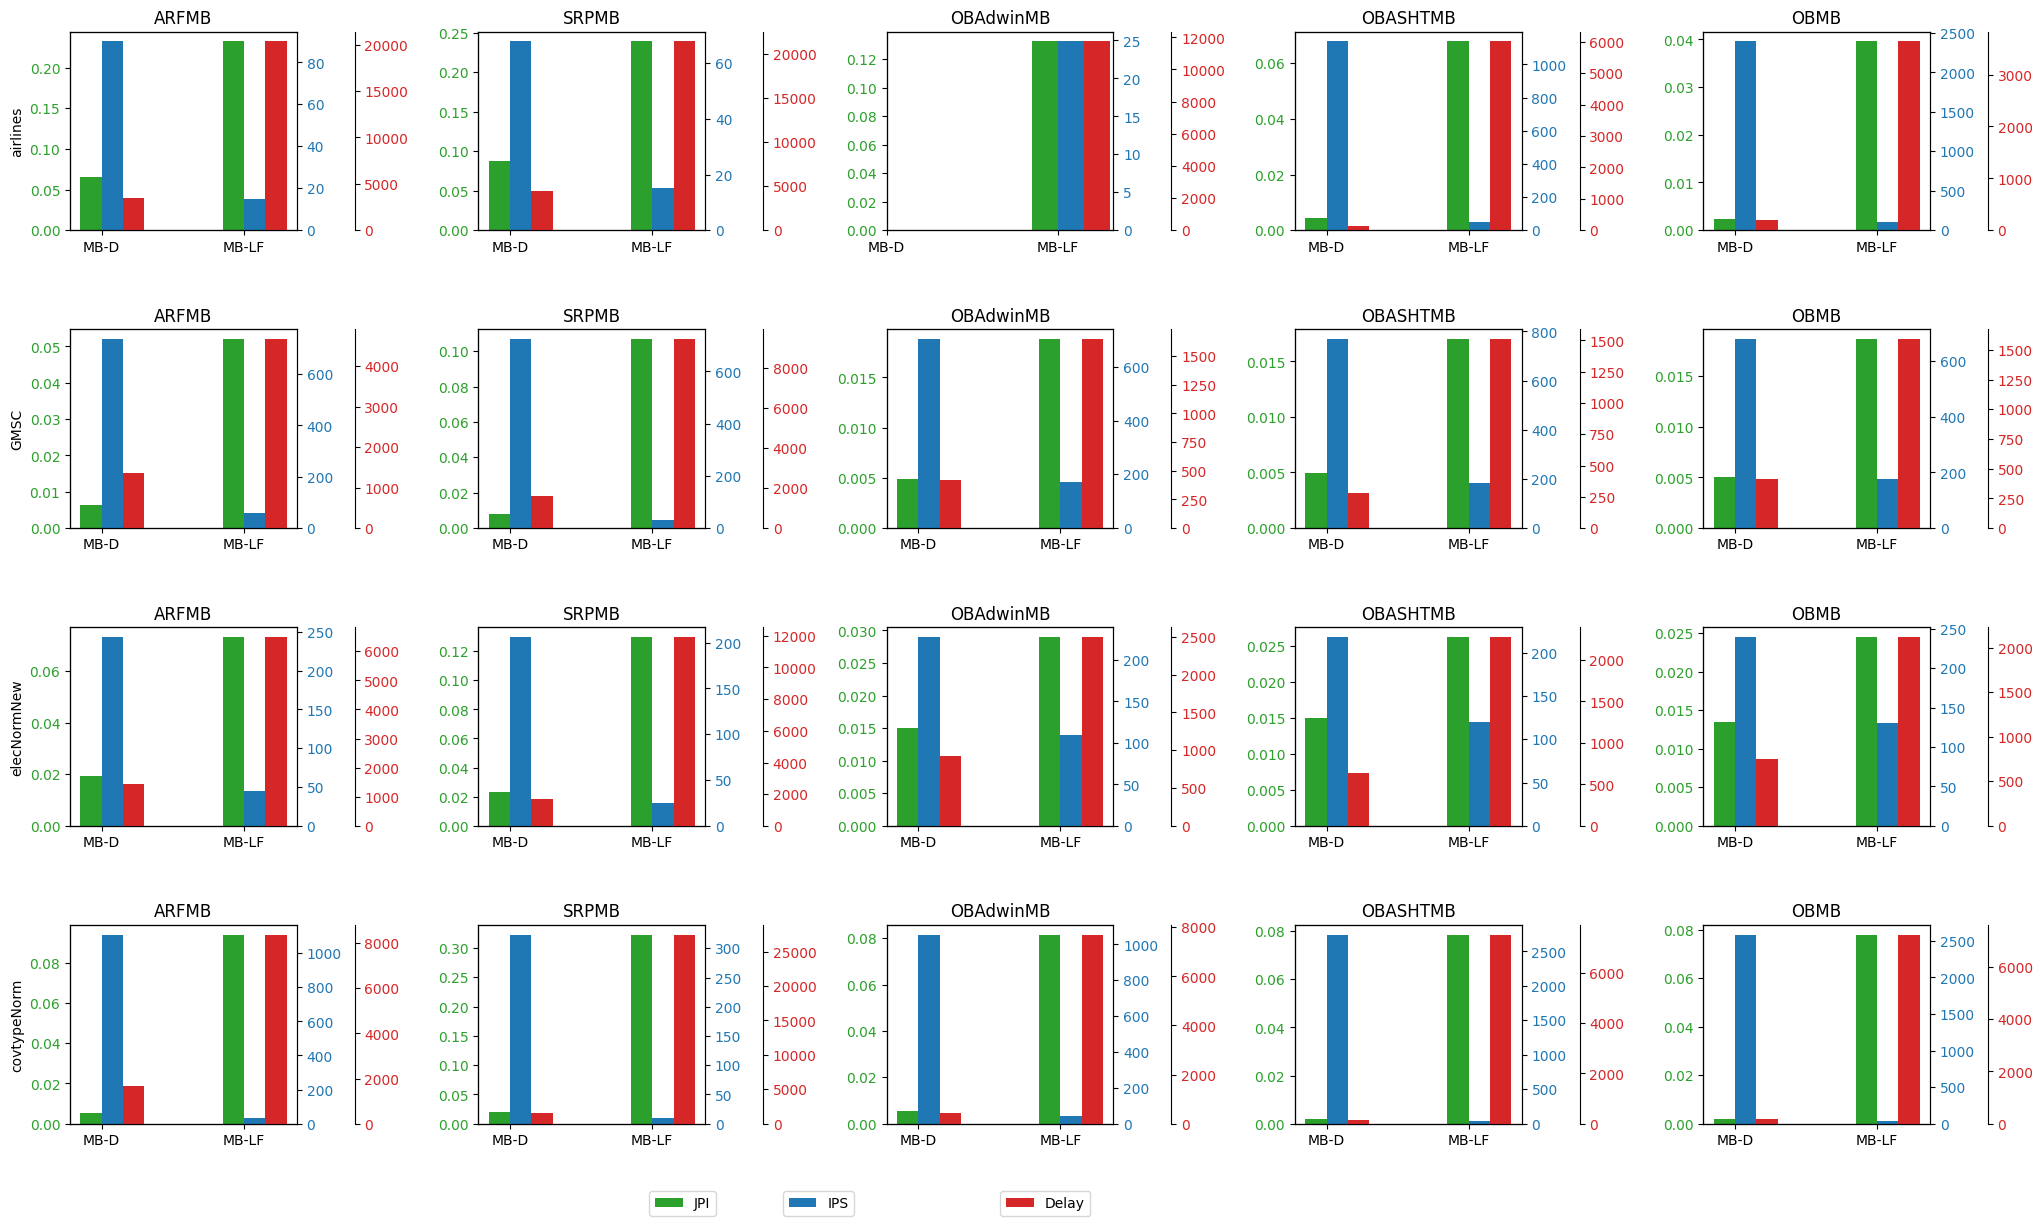

In [974]:
df = pd.concat([df_10, df_mbd])

df = df.loc[:,['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'label', 'delay']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']

gen_graph_joules(df, None)

# Comparando o dinamico com a taxa de vazao de 50%

/Users/reginaldoluisdeluna/.local/lib/python3.11/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'layout' and 'tight_layout' cannot be used together. Please use 'layout' only.
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
8,airlines,ARFMB,MB-D,65.5818,"11,001.0000",122.0730,0.0658,664.7153,4,MB-D,"3,423.0000",90.1182
0,airlines,ARFMB,MB-LF,71.3600,"3,000.0000",123.5960,0.1456,424.9883,4,MB-LF,"13,996.0000",24.2726


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
5,airlines,SRPMB,MB-D,65.5250,"8,168.0000",120.1530,0.0877,652.2806,4,MB-D,"4,416.0000",67.9800
179,airlines,SRPMB,MB-LF,72.6400,"3,000.0000",126.1040,0.1594,463.8597,4,MB-LF,"15,207.0000",23.7899


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
3,airlines,OBAdwinMB,MB-D,NaN,NaN,NaN,NaN,NaN,4,MB-D,NaN,NaN
138,airlines,OBAdwinMB,MB-LF,63.9200,"8,000.0000",119.9970,0.0532,405.2650,4,MB-LF,"4,573.0000",66.6683


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
2,airlines,OBASHTMB,MB-D,67.3241,"136,898.0000",120.0010,0.0044,546.2525,4,MB-D,150.0000,"1,140.8072"
168,airlines,OBASHTMB,MB-LF,64.5288,"30,000.0000",122.0370,0.0203,580.0162,4,MB-LF,"1,905.0000",245.8271


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
18,airlines,OBMB,MB-D,62.6699,"287,549.0000",120.0010,0.0024,625.6982,4,MB-D,188.0000,"2,396.2217"
6,airlines,OBMB,MB-LF,63.5423,"26,500.0000",123.1220,0.0269,679.4861,4,MB-LF,"2,314.0000",215.2337


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
17,GMSC,ARFMB,MB-D,93.5455,"88,072.0000",119.5750,0.0063,508.9253,4,MB-D,"1,348.0000",736.5419
2,GMSC,ARFMB,MB-LF,93.5895,"19,500.0000",119.8200,0.0202,380.5483,4,MB-LF,"1,868.0000",162.7441


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
6,GMSC,SRPMB,MB-D,93.5035,"86,273.0000",119.1500,0.0077,606.9641,4,MB-D,"1,603.0000",724.0705
160,GMSC,SRPMB,MB-LF,93.5556,"9,500.0000",120.0050,0.0415,381.4672,4,MB-LF,"3,702.0000",79.1634


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
15,GMSC,OBAdwinMB,MB-D,93.4571,"84,001.0000",119.3000,0.0049,369.1865,4,MB-D,420.0000,704.1157
24,GMSC,OBAdwinMB,MB-LF,93.3421,"57,500.0000",120.0160,0.0071,390.9469,4,MB-LF,652.0000,479.1028


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
13,GMSC,OBASHTMB,MB-D,93.3722,"91,751.0000",119.2610,0.0049,405.9328,4,MB-D,277.0000,769.3294
211,GMSC,OBASHTMB,MB-LF,93.2865,"104,500.0000",119.9900,0.0038,375.1266,4,MB-LF,324.0000,870.9059


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
7,GMSC,OBMB,MB-D,93.2741,"81,001.0000",119.1520,0.0051,371.3571,4,MB-D,409.0000,679.8123
3,GMSC,OBMB,MB-LF,93.3413,"101,000.0000",119.9990,0.0039,374.3653,4,MB-LF,348.0000,841.6737


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
9,elecNormNew,ARFMB,MB-D,88.9345,"29,001.0000",119.0790,0.0195,514.8534,4,MB-D,"1,425.0000",243.5442
128,elecNormNew,ARFMB,MB-LF,88.5867,"8,000.0000",120.0050,0.0502,388.4962,4,MB-LF,"4,332.0000",66.6639


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
10,elecNormNew,SRPMB,MB-D,90.3273,"24,760.0000",119.9360,0.0233,525.2697,4,MB-D,"1,672.0000",206.4434
175,elecNormNew,SRPMB,MB-LF,92.5714,"4,000.0000",119.9800,0.0994,384.8425,4,MB-LF,"8,385.0000",33.3389


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
12,elecNormNew,OBAdwinMB,MB-D,86.6519,"27,179.0000",119.1910,0.0150,367.2978,4,MB-D,924.0000,228.0290
50,elecNormNew,OBAdwinMB,MB-LF,84.5964,"28,500.0000",119.8670,0.0137,372.1111,4,MB-LF,"1,210.0000",237.7635


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
4,elecNormNew,OBASHTMB,MB-D,78.7462,"26,001.0000",119.0830,0.0150,350.2819,4,MB-D,637.0000,218.3435
164,elecNormNew,OBASHTMB,MB-LF,78.0899,"45,000.0000",95.4630,0.0071,301.4648,4,MB-LF,612.0000,471.3868


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
19,elecNormNew,OBMB,MB-D,77.5404,"28,564.0000",119.1770,0.0135,345.6626,4,MB-D,750.0000,239.6771
79,elecNormNew,OBMB,MB-LF,77.1371,"45,000.0000",93.6680,0.0070,296.6674,4,MB-LF,607.0000,480.4202


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
16,covtypeNorm,ARFMB,MB-D,90.0430,"135,001.0000",121.6890,0.0055,664.6703,4,MB-D,"1,670.0000","1,109.3936"
106,covtypeNorm,ARFMB,MB-LF,76.7714,"11,000.0000",119.8180,0.0377,400.9377,4,MB-LF,"3,311.0000",91.8059


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
11,covtypeNorm,SRPMB,MB-D,93.6127,"39,501.0000",122.1370,0.0192,702.2111,4,MB-D,"1,511.0000",323.4155
214,covtypeNorm,SRPMB,MB-LF,78.5333,"2,000.0000",119.9570,0.1993,382.5941,4,MB-LF,"14,882.0000",16.6726


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
1,covtypeNorm,OBAdwinMB,MB-D,83.1207,"127,151.0000",120.5580,0.0053,605.9285,4,MB-D,451.0000,"1,054.6874"
95,covtypeNorm,OBAdwinMB,MB-LF,67.8080,"13,000.0000",119.8160,0.0316,397.0969,4,MB-LF,"2,950.0000",108.4997


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
0,covtypeNorm,OBASHTMB,MB-D,75.9757,"329,361.0000",120.0010,0.0018,529.6974,4,MB-D,137.0000,"2,744.6521"
81,covtypeNorm,OBASHTMB,MB-LF,64.9837,"25,000.0000",120.0960,0.0173,411.9082,4,MB-LF,"2,010.0000",208.1668


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
20,covtypeNorm,OBMB,MB-D,77.4687,"310,001.0000",119.9050,0.0019,533.4017,4,MB-D,168.0000,"2,585.3885"
156,covtypeNorm,OBMB,MB-LF,64.3350,"23,960.0000",119.8480,0.0180,409.8383,4,MB-LF,"2,123.0000",199.9199


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/138958911.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/138958911.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


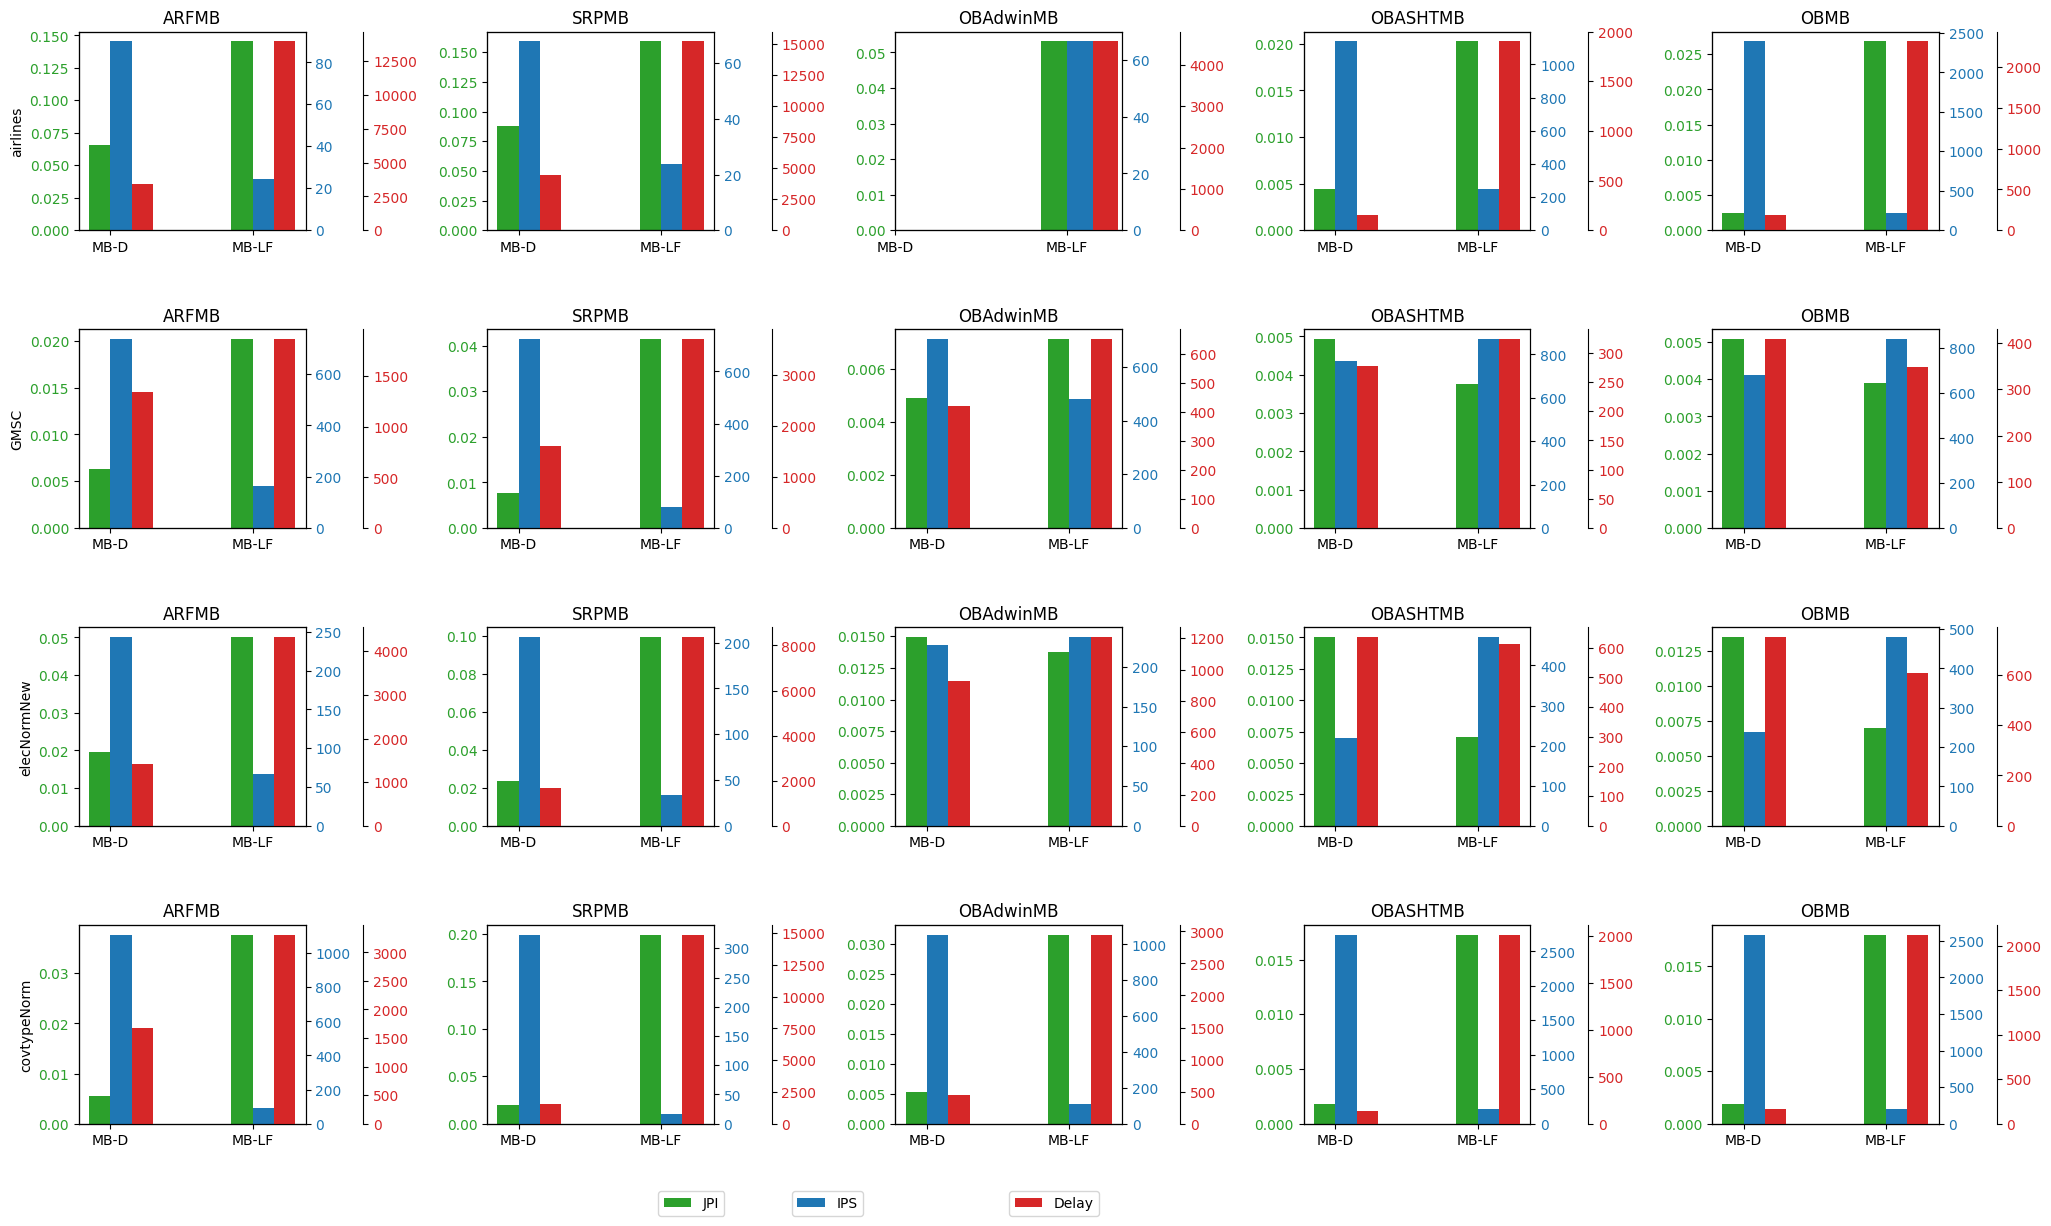

In [975]:
df = pd.concat([df_50, df_mbd])

df = df.loc[:,['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'label', 'delay']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']

gen_graph_joules(df, None)

# Comparando o dinamico com a taxa de 90%

/Users/reginaldoluisdeluna/.local/lib/python3.11/site-packages/matplotlib_inline/backend_inline.py:27: UserWarning: The Figure parameters 'layout' and 'tight_layout' cannot be used together. Please use 'layout' only.
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
8,airlines,ARFMB,MB-D,65.5818,"11,001.0000",122.0730,0.0658,664.7153,4,MB-D,"3,423.0000",90.1182
184,airlines,ARFMB,MB-LF,64.9158,"10,000.0000",121.0230,0.0654,633.4965,4,MB-LF,"5,787.0000",82.6289


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
5,airlines,SRPMB,MB-D,65.5250,"8,168.0000",120.1530,0.0877,652.2806,4,MB-D,"4,416.0000",67.9800
93,airlines,SRPMB,MB-LF,64.3125,"8,500.0000",124.9040,0.0817,672.5066,4,MB-LF,"7,172.0000",68.0523


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
3,airlines,OBAdwinMB,MB-D,NaN,NaN,NaN,NaN,NaN,4,MB-D,NaN,NaN
199,airlines,OBAdwinMB,MB-LF,62.8194,"16,000.0000",121.4340,0.0318,490.5615,4,MB-LF,"3,051.0000",131.7588


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
2,airlines,OBASHTMB,MB-D,67.3241,"136,898.0000",120.0010,0.0044,546.2525,4,MB-D,150.0000,"1,140.8072"
65,airlines,OBASHTMB,MB-LF,65.2694,"36,500.0000",121.6060,0.0190,664.2860,4,MB-LF,"1,658.0000",300.1497


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
18,airlines,OBMB,MB-D,62.6699,"287,549.0000",120.0010,0.0024,625.6982,4,MB-D,188.0000,"2,396.2217"
194,airlines,OBMB,MB-LF,61.5589,"73,500.0000",120.0010,0.0065,457.2615,4,MB-LF,633.0000,612.4949


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
17,GMSC,ARFMB,MB-D,93.5455,"88,072.0000",119.5750,0.0063,508.9253,4,MB-D,"1,348.0000",736.5419
135,GMSC,ARFMB,MB-LF,93.5204,"37,138.0000",119.8600,0.0118,419.2988,4,MB-LF,"1,126.0000",309.8448


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
6,GMSC,SRPMB,MB-D,93.5035,"86,273.0000",119.1500,0.0077,606.9641,4,MB-D,"1,603.0000",724.0705
193,GMSC,SRPMB,MB-LF,93.6180,"17,971.0000",120.0090,0.0228,396.9898,4,MB-LF,"2,277.0000",149.7471


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
15,GMSC,OBAdwinMB,MB-D,93.4571,"84,001.0000",119.3000,0.0049,369.1865,4,MB-D,420.0000,704.1157
72,GMSC,OBAdwinMB,MB-LF,93.4572,"102,429.0000",119.9930,0.0042,405.4087,4,MB-LF,395.0000,853.6248


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
13,GMSC,OBASHTMB,MB-D,93.3722,"91,751.0000",119.2610,0.0049,405.9328,4,MB-D,277.0000,769.3294
76,GMSC,OBASHTMB,MB-LF,93.3595,"111,229.0000",120.0110,0.0037,396.5080,4,MB-LF,354.0000,926.8234


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
7,GMSC,OBMB,MB-D,93.2741,"81,001.0000",119.1520,0.0051,371.3571,4,MB-D,409.0000,679.8123
78,GMSC,OBMB,MB-LF,93.4141,"106,484.0000",120.0010,0.0039,393.1736,4,MB-LF,370.0000,887.3593


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
9,elecNormNew,ARFMB,MB-D,88.9345,"29,001.0000",119.0790,0.0195,514.8534,4,MB-D,"1,425.0000",243.5442
14,elecNormNew,ARFMB,MB-LF,79.4217,"26,955.0000",119.8670,0.0174,450.4781,4,MB-LF,"1,628.0000",224.8742


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
10,elecNormNew,SRPMB,MB-D,90.3273,"24,760.0000",119.9360,0.0233,525.2697,4,MB-D,"1,672.0000",206.4434
91,elecNormNew,SRPMB,MB-LF,81.4024,"14,975.0000",119.8280,0.0319,458.4081,4,MB-LF,"2,907.0000",124.9708


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
12,elecNormNew,OBAdwinMB,MB-D,86.6519,"27,179.0000",119.1910,0.0150,367.2978,4,MB-D,924.0000,228.0290
87,elecNormNew,OBAdwinMB,MB-LF,77.7783,"45,312.0000",80.2210,0.0063,270.5259,4,MB-LF,615.0000,564.8396


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
4,elecNormNew,OBASHTMB,MB-D,78.7462,"26,001.0000",119.0830,0.0150,350.2819,4,MB-D,637.0000,218.3435
101,elecNormNew,OBASHTMB,MB-LF,77.6511,"45,312.0000",74.4310,0.0059,250.7713,4,MB-LF,553.0000,608.7786


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
19,elecNormNew,OBMB,MB-D,77.5404,"28,564.0000",119.1770,0.0135,345.6626,4,MB-D,750.0000,239.6771
157,elecNormNew,OBMB,MB-LF,77.1646,"45,312.0000",68.2180,0.0054,228.5047,4,MB-LF,510.0000,664.2235


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
16,covtypeNorm,ARFMB,MB-D,90.0430,"135,001.0000",121.6890,0.0055,664.6703,4,MB-D,"1,670.0000","1,109.3936"
122,covtypeNorm,ARFMB,MB-LF,62.1867,"22,762.0000",119.8440,0.0202,443.8489,4,MB-LF,"2,055.0000",189.9302


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
11,covtypeNorm,SRPMB,MB-D,93.6127,"39,501.0000",122.1370,0.0192,702.2111,4,MB-D,"1,511.0000",323.4155
15,covtypeNorm,SRPMB,MB-LF,60.2833,"6,500.0000",120.3750,0.0676,426.7695,4,MB-LF,"6,699.0000",53.9979


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
1,covtypeNorm,OBAdwinMB,MB-D,83.1207,"127,151.0000",120.5580,0.0053,605.9285,4,MB-D,451.0000,"1,054.6874"
61,covtypeNorm,OBAdwinMB,MB-LF,68.2375,"25,158.0000",119.8870,0.0181,432.8026,4,MB-LF,"2,039.0000",209.8476


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
0,covtypeNorm,OBASHTMB,MB-D,75.9757,"329,361.0000",120.0010,0.0018,529.6974,4,MB-D,137.0000,"2,744.6521"
132,covtypeNorm,OBASHTMB,MB-LF,72.6167,"42,500.0000",120.0340,0.0097,391.4267,4,MB-LF,896.0000,354.0664


,dataset,algorithm,batch_size,acc,instances,time,JPI,joules,cores,label,delay,IPS
20,covtypeNorm,OBMB,MB-D,77.4687,"310,001.0000",119.9050,0.0019,533.4017,4,MB-D,168.0000,"2,585.3885"
39,covtypeNorm,OBMB,MB-LF,71.9302,"43,500.0000",120.3110,0.0109,454.6489,4,MB-LF,"1,268.0000",361.5630


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/138958911.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_31710/138958911.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


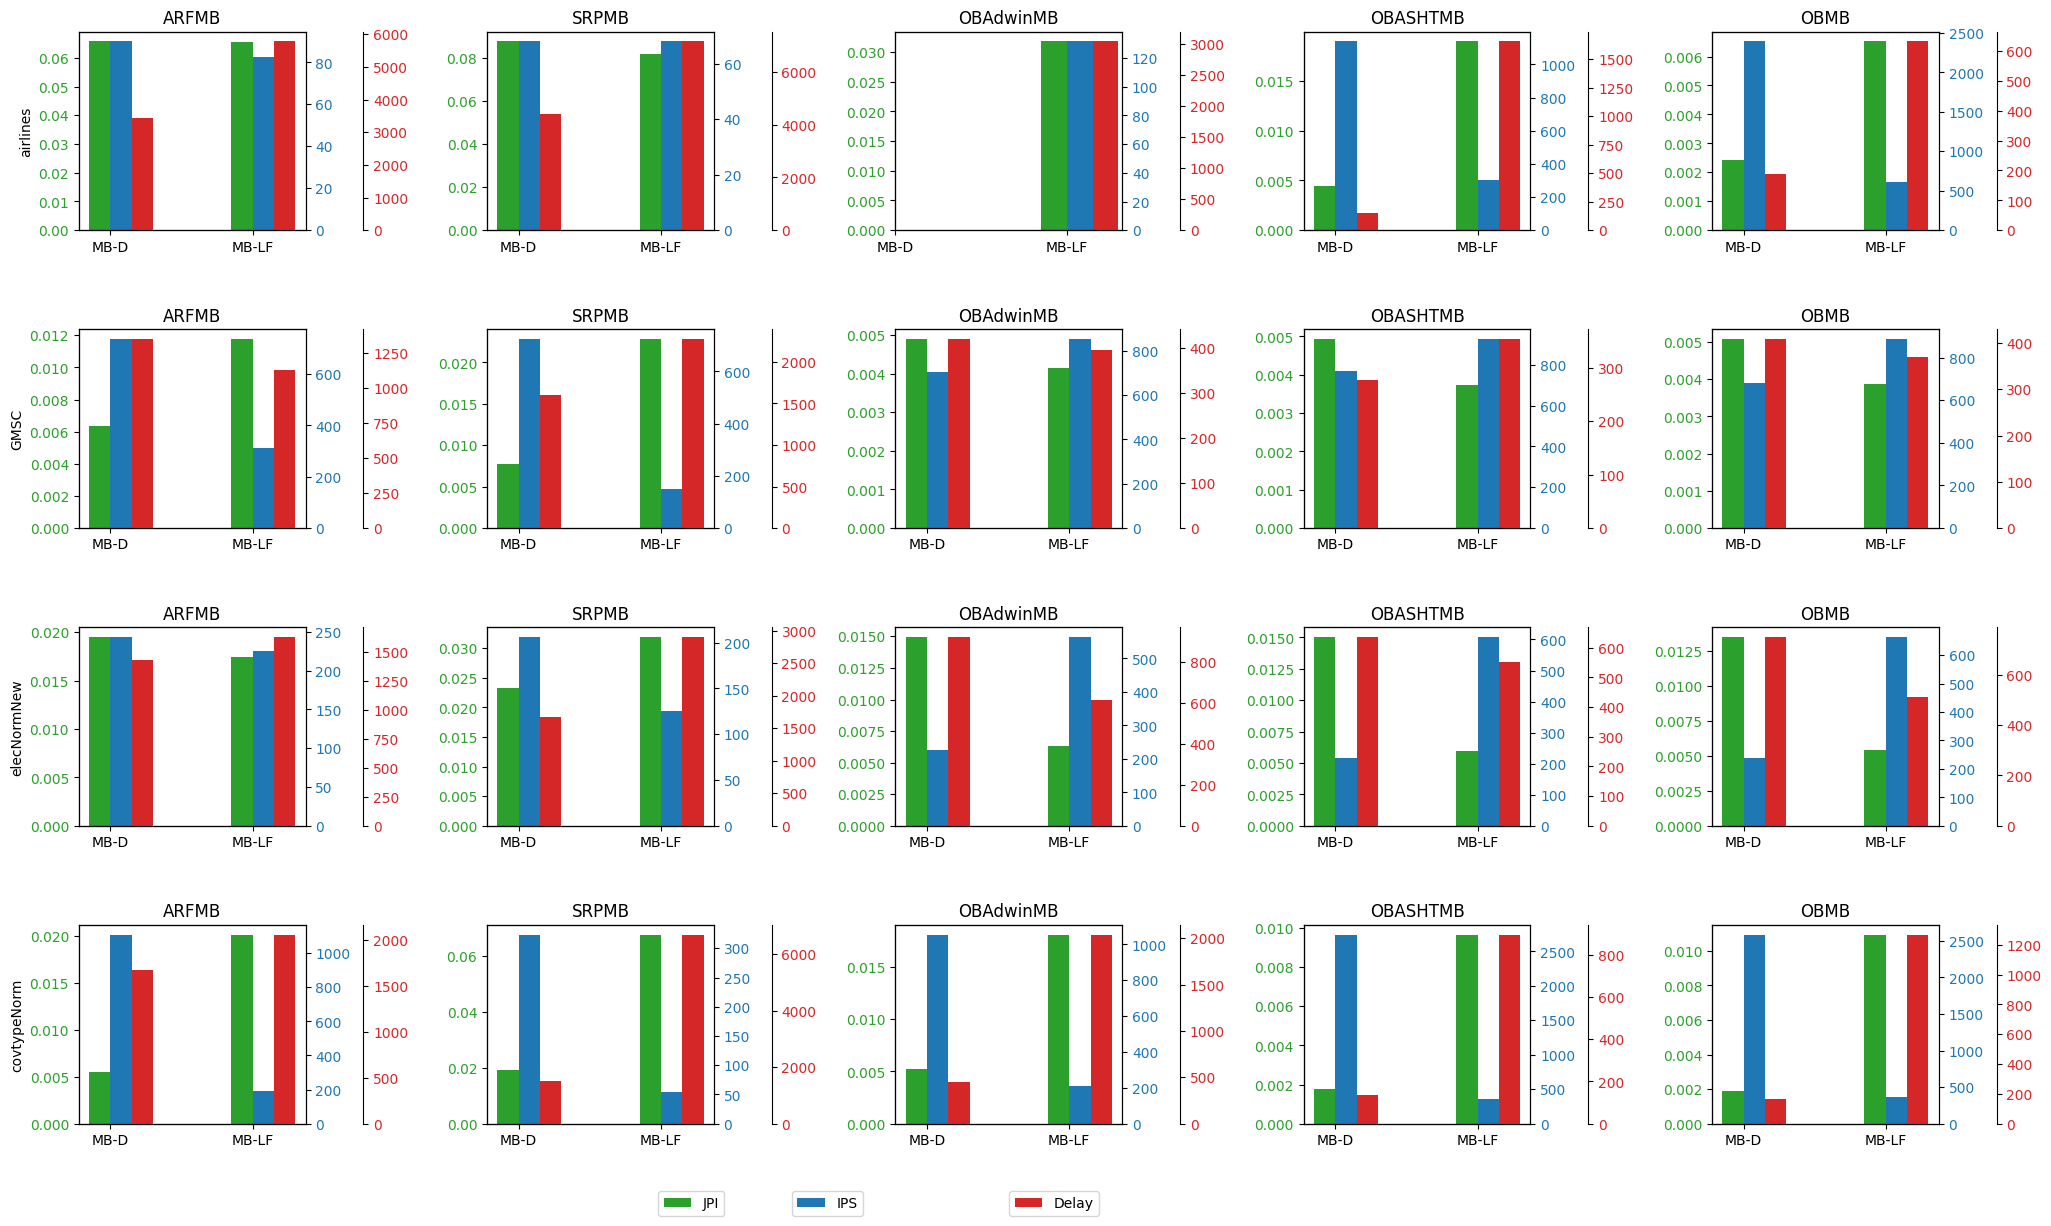

In [976]:
df = pd.concat([df_90, df_mbd])

df = df.loc[:,['dataset','algorithm','batch_size','acc', 'instances', 'time', 'JPI', 'joules', 'cores', 'label', 'delay']]
df = select_columns_and_rename_values(df)
df['IPS'] = df['instances'] / df['time']

gen_graph_joules(df, None)

## calculate median and maximums

In [977]:
def generate_reduction_percentage(df):
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']

    response = {
        'airlines': {
            'ARF': {},
            'LBag': {},
            'SRP': {},
            'OBAdwin': {},
            'OBASHT': {},
            'OB': {}
        },
        'GMSC': {
            'ARF': {},
            'LBag': {},
            'SRP': {},
            'OBAdwin': {},
            'OBASHT': {},
            'OB': {}
        },
        'elecNormNew': {
            'ARF': {},
            'LBag': {},
            'SRP': {},
            'OBAdwin': {},
            'OBASHT': {},
            'OB': {}
        },
        'covtypeNorm': {
            'ARF': {},
            'LBag': {},
            'SRP': {},
            'OBAdwin': {},
            'OBASHT': {},
            'OB': {}
        }
    }

    for ds in datasets:
        current_df = df[(df.dataset == ds)]

        my_id_ds = datasets.index(ds)

        #selects the correct position in the grid
        for alg in algorithms:
            df_mapping = pd.DataFrame({
                'label': ['S', 'FH2', 'FH4', 'CL2', 'CL4', 'MB', 'MB-LF'],
            })
            sort_mapping = df_mapping.reset_index().set_index('label')
            dfalg['label_num'] = dfalg['label'].map(sort_mapping['index'])

            dfalg = dfalg.drop_duplicates().sort_values('label_num')
            dfalg = dfalg.iloc[:-1 , :] # remove duplicidade sequencial
            dfalg = dfalg.iloc[1: , :] # remove duplicidade sequencial
     
            my_id = algorithms.index(alg)

            joules_sequential = dfalg[dfalg.label == 'S']['joules'].iloc[0]
            joules_mb = dfalg[dfalg.label == 'MB']['joules'].iloc[0]
            joules_mblf = dfalg[dfalg.label == 'MB-LF']['joules'].iloc[0]

            response[ds][alg] = {
                'joules_sequential': joules_sequential,
                'joules_mb': joules_mb,
                'joules_mblf': joules_mblf,
                'reducao_mb': (joules_sequential / joules_mb),
                'reducao_mblf': (joules_sequential / joules_mblf)
            }

    return response
            

In [978]:
def generate_median_all(df_90, df_50, df_10):
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']

    total_mb = []
    total_mblf = []
    for ds in datasets:
        for alg in algorithms:
            total_mb.append(df_90[ds][alg]['reducao_mb'])
            total_mb.append(df_50[ds][alg]['reducao_mb'])
            total_mb.append(df_10[ds][alg]['reducao_mb'])

            total_mblf.append(df_90[ds][alg]['reducao_mblf'])
            total_mblf.append(df_50[ds][alg]['reducao_mblf'])
            total_mblf.append(df_10[ds][alg]['reducao_mblf'])

    print({
        'mb_median': round(np.mean(total_mb) * 100, 2),
        'mblf_median': round(np.mean(total_mblf) * 100, 2),
        'mb_maximum': round(np.max(total_mb) * 100, 2),
        'mblf_maximum': round(np.max(total_mblf) * 100, 2)
    })

In [979]:
df_generate_90 = generate_reduction_percentage(df_90)
df_generate_50 = generate_reduction_percentage(df_50)
df_generate_10 = generate_reduction_percentage(df_10)

generate_median_all(df_generate_90, df_generate_50, df_generate_10)



UnboundLocalError: cannot access local variable 'dfalg' where it is not associated with a value

## Average value and maximum value when compare sequential mode

- Em média MB obteve 96% de melhoria na eficiência energética, e 169% de melhoria no melhor caso. 
- Em média MB-LF obteve 136% de melhoria na eficiência energética, e 456% de melhoria no melhor caso. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure()
ax = plt.axes(projection = "3d")

# series = ['.', 'VFH2', 'VFH4', 'CL2', 'CL4', 'MB', 'MB-LF', 'S']
series = ['FH2', 'FH4', 'CL2', 'CL4', 'MB', 'MB-LF', 'S']
datasets = ['airl', 'GMSC', 'elec', 'covtype']

# data = np.array([[0, 20.4, 2.1, 1.6, 1.6, 1.6, 1.6, 1.8],
#                  [0, 18.1, 1.2, 2.3, 2.3, 2.3, 2.3, 1.3],
#                  [0, 27.8, 1.4, 1.3, 1.3, 1.3, 1.3, 0.8],
#                  [0, 15.2, 5.2, 5.3, 5.4, 5.5, 5.6, 5.1]])

data = np.array([[20.4, 2.1, 1.6, 1.6, 1.6, 1.6, 1.8],
                 [18.1, 1.2, 2.3, 2.3, 2.3, 2.3, 1.3],
                 [27.8, 1.4, 1.3, 1.3, 1.3, 1.3, 0.8],
                 [15.2, 5.2, 5.3, 5.4, 5.5, 5.6, 5.1]])
 
numOfCols = 7
numOfRows = 4
 
xpos = np.arange(0, numOfCols, 1)
ypos = np.arange(0, numOfRows, 1)
xpos, ypos = np.meshgrid(xpos + 1.0, ypos + 1.0)
 
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(numOfCols * numOfRows)
 
dx = np.ones(numOfRows * numOfCols) * 0.5
dy = np.ones(numOfCols * numOfRows) * 0.5
dz = data.flatten()

ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color='b', alpha=0.5)
ax.set_xticklabels(series)
ax.set_yticklabels(datasets)
 
ax.set_xlabel('Algorithm')
ax.set_ylabel('Datasets')
ax.set_zlabel('JPI')

# elev = 10
# azim = -85
# roll = 0
# ax.view_init(elev, azim, roll)
 
plt.show()